In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### PREPROCESS DATA

In [11]:
# --- Load and subset columns ---
df = pd.read_csv("../datasets/Chamau_2001-2024.csv")


In [14]:
cols = [
    # Target
    "FN2O_L3.1_L3.3_CUT_50_QCF0",

    # Timestamp
    "TIMESTAMP_MIDDLE",
    
    # Predictors
    "NEE_L3.1_L3.3_CUT_50_QCF_gfRF",
    "GPP_NT_CUT_50_gfRF",
    "RECO_NT_CUT_50_gfRF",
    "SW_IN_T1_2_1",
    "TA_T1_2_1",
    "PREC_RAIN_TOT_GF1_0.5_1",
    "VPD_T1_2_1",
    "SWC_GF1_0.05_1",
    "SWC_GF1_0.15_1",
    "TS_GF1_0.04_1",
    "TS_GF1_0.15_1",

    # Management A & B
    "MGMT_MOWING_PARCEL-A",
    "MGMT_FERT_ORG_PARCEL-A",
    "MGMT_FERT_MIN_PARCEL-A",
    "MGMT_GRAZING_PARCEL-A",
    "MGMT_SOILCULTIVATION_PARCEL-A",
    "MGMT_MOWING_PARCEL-B",
    "MGMT_FERT_ORG_PARCEL-B",
    "MGMT_FERT_MIN_PARCEL-B",
    "MGMT_GRAZING_PARCEL-B",
    "MGMT_SOILCULTIVATION_PARCEL-B",

    # Wind direction
    "WD",
]

chamau = df[cols].rename(columns={
    "FN2O_L3.1_L3.3_CUT_50_QCF0": "N2O_Flux",
    "TIMESTAMP_MIDDLE": "Timestamp",
    "NEE_L3.1_L3.3_CUT_50_QCF_gfRF": "NEE",
    "GPP_NT_CUT_50_gfRF": "GPP",
    "RECO_NT_CUT_50_gfRF": "RECO",
    "SW_IN_T1_2_1": "SolarRadiation",
    "TA_T1_2_1": "AirTemp",
    "PREC_RAIN_TOT_GF1_0.5_1": "Precipitation",
    "VPD_T1_2_1": "VPD",
    "SWC_GF1_0.05_1": "SoilWater_5cm",
    "SWC_GF1_0.15_1": "SoilWater_15cm",
    "TS_GF1_0.04_1": "SoilTemp_4cm",
    "TS_GF1_0.15_1": "SoilTemp_15cm",
})

# ======================================================================
# --- 2. Parse timestamp + time components ------------------------------
# ======================================================================
chamau["Timestamp"] = pd.to_datetime(chamau["Timestamp"])
chamau = chamau.sort_values("Timestamp")

chamau["year"] = chamau["Timestamp"].dt.year
chamau["month"] = chamau["Timestamp"].dt.month
chamau["hour"] = chamau["Timestamp"].dt.hour
chamau["day"]   = chamau["Timestamp"].dt.day

# ======================================================================
# --- 3. Determine Parcel: A, B, or Uncertain ---------------------------
# ======================================================================
def assign_parcel(wd):
    if 110 <= wd <= 210:
        return "A"
    elif (wd >= 290) or (wd <= 30):
        return "B"
    else:
        return "Uncertain"

chamau["Parcel"] = chamau["WD"].apply(assign_parcel)

# ======================================================================
# --- 4. Create A/B-specific management columns -------------------------
# ======================================================================
management_events = ["Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"]

management_map = {
    "A": {
        "Mowing": "MGMT_MOWING_PARCEL-A",
        "FertilizerOrganic": "MGMT_FERT_ORG_PARCEL-A",
        "FertilizerMineral": "MGMT_FERT_MIN_PARCEL-A",
        "Grazing": "MGMT_GRAZING_PARCEL-A",
        "SoilCultivation": "MGMT_SOILCULTIVATION_PARCEL-A",
    },
    "B": {
        "Mowing": "MGMT_MOWING_PARCEL-B",
        "FertilizerOrganic": "MGMT_FERT_ORG_PARCEL-B",
        "FertilizerMineral": "MGMT_FERT_MIN_PARCEL-B",
        "Grazing": "MGMT_GRAZING_PARCEL-B",
        "SoilCultivation": "MGMT_SOILCULTIVATION_PARCEL-B",
    },
}

for event in management_events:
    chamau[f"{event}_A"] = chamau[management_map["A"][event]]
    chamau[f"{event}_B"] = chamau[management_map["B"][event]]

# ======================================================================
# --- 5. Compute A/B-specific "days since" BEFORE parcel collapse -------
# ======================================================================
def days_since_event(series, max_days=30):
    days = np.full(len(series), np.nan)
    last_idx = None
    for i, val in enumerate(series):
        if val == 1:
            last_idx = i
            days[i] = 0
        elif last_idx is not None:
            dt = (series.index[i] - series.index[last_idx]).total_seconds() / 86400
            days[i] = min(dt, max_days)
        else:
            days[i] = max_days
    return days

# Use Timestamp as index for time deltas
chamau = chamau.set_index("Timestamp").sort_index()

for event in management_events:
    chamau[f"DaysSince_{event}_A"] = days_since_event(chamau[f"{event}_A"])
    chamau[f"DaysSince_{event}_B"] = days_since_event(chamau[f"{event}_B"])

# ======================================================================
# --- 6. Create parcel-resolved management + days-since -----------------
# ======================================================================
for event in management_events:
    chamau[event] = np.where(
        chamau["Parcel"] == "A", chamau[f"{event}_A"],
        np.where(
            chamau["Parcel"] == "B", chamau[f"{event}_B"],
            0.5 * (chamau[f"{event}_A"] + chamau[f"{event}_B"])  # Uncertain
        )
    )

    chamau[f"DaysSince_{event}"] = np.where(
        chamau["Parcel"] == "A", chamau[f"DaysSince_{event}_A"],
        np.where(
            chamau["Parcel"] == "B", chamau[f"DaysSince_{event}_B"],
            0.5 * (chamau[f"DaysSince_{event}_A"] + chamau[f"DaysSince_{event}_B"])
        )
    )

# ======================================================================
# --- 7. Cleanup extra columns -----------------------------------------
# ======================================================================
drop_cols = (
    [management_map["A"][ev] for ev in management_events] +
    [management_map["B"][ev] for ev in management_events] +
    [f"{ev}_A" for ev in management_events] +
    [f"{ev}_B" for ev in management_events] +
    [f"DaysSince_{ev}_A" for ev in management_events] +
    [f"DaysSince_{ev}_B" for ev in management_events]
)

chamau = chamau.drop(columns=drop_cols, errors="ignore")

# ======================================================================
# --- 8. Prepare for DAILY aggregation + lag features -------------------
# ======================================================================
# Make/refresh Date safely
chamau = chamau.drop(columns=["Date"], errors="ignore")
chamau["Date"] = chamau.index.floor("D")

# --- Daily aggregation ---
daily = (
    chamau.groupby(["Parcel", "Date"])
    .agg({
        "NEE": "mean",
        "GPP": "mean",
        "RECO": "mean",
        "SolarRadiation": "mean",
        "AirTemp": "mean",
        "VPD": "mean",
        "SoilWater_5cm": "mean",
        "SoilWater_15cm": "mean",
        "SoilTemp_4cm": "mean",
        "SoilTemp_15cm": "mean",
        "Precipitation": "sum",
    })
    .add_suffix("_daily")
    .reset_index()
    .sort_values(["Parcel", "Date"])
)

meteo_daily = [
    "NEE_daily","GPP_daily","RECO_daily",
    "SolarRadiation_daily","AirTemp_daily","VPD_daily",
    "SoilWater_5cm_daily","SoilWater_15cm_daily",
    "SoilTemp_4cm_daily","SoilTemp_15cm_daily",
    "Precipitation_daily",
]

lag_days     = [1, 3, 5, 7]
roll_windows = [3, 5, 7]

lagged_list = []
for parcel, group in daily.groupby("Parcel"):
    group = group.set_index("Date").sort_index()
    group.index.name = "Date"

    lag_cols = []

    # Exact daily lags
    for var in meteo_daily:
        base = var.replace("_daily", "")
        for lag in lag_days:
            lag_cols.append(group[var].shift(lag).rename(f"{base}_lag{lag}d_daily"))

    # Rolling windows excluding current day → shift(1)
    shifted = group[meteo_daily].shift(1)
    for var in meteo_daily:
        base = var.replace("_daily", "")
        for w in roll_windows:
            lag_cols.append(
                shifted[var].rolling(w, min_periods=1).mean().rename(f"{base}_roll{w}d_mean")
            )
            lag_cols.append(
                shifted[var].rolling(w, min_periods=1).sum().rename(f"{base}_roll{w}d_sum")
            )

    # Precipitation windows (use daily totals)
    shifted_precip = group["Precipitation_daily"].shift(1)
    for w in roll_windows:
        lag_cols.append(
            shifted_precip.rolling(w, min_periods=1).mean().rename(f"Precipitation_roll{w}d_mean")
        )
        lag_cols.append(
            shifted_precip.rolling(w, min_periods=1).sum().rename(f"Precipitation_roll{w}d_sum")
        )

    feat = pd.concat(lag_cols, axis=1)
    feat.index.name = "Date"
    feat = feat.reset_index()
    feat.insert(0, "Parcel", parcel)
    lagged_list.append(feat)

daily_features = pd.concat(lagged_list, ignore_index=True)
daily_features = daily_features[
    ["Parcel", "Date"] + [c for c in daily_features.columns if ("lag" in c or "roll" in c)]
]

# --- Merge back to hourly dataset ---
chamau = chamau.drop(columns=["Date"], errors="ignore")
chamau = chamau.reset_index().rename(columns={"index": "Timestamp"})

chamau["Date"] = chamau["Timestamp"].dt.floor("D")
chamau = chamau.merge(daily_features, how="left", on=["Parcel", "Date"])

chamau = chamau.drop(columns=["Date"])
chamau = chamau.set_index("Timestamp").sort_index()

# Keep a pre-filter full copy (hourly + lags + days-since)
chamau_lag_full = chamau.copy()

# ======================================================================
# --- 9. Filter dataset, log-transform, split by parcel -----------------
# ======================================================================
chamau_lag = chamau[chamau["year"] >= 2014].copy()
chamau_lag = chamau_lag[chamau_lag["N2O_Flux"].notna()].copy()

chamau_lag = chamau_lag.reset_index().rename(columns={"index": "Timestamp"})

chamau_lag["N2O_Flux_ln"] = np.where(
    chamau_lag["N2O_Flux"] > 0,
    np.log1p(chamau_lag["N2O_Flux"]),
    0
)

chamau_A = chamau_lag[chamau_lag["Parcel"] == "A"].copy()
chamau_B = chamau_lag[chamau_lag["Parcel"] == "B"].copy()
chamau_uncertain = chamau_lag[chamau_lag["Parcel"] == "Uncertain"].copy()

chamau_lag.head()

/home/anding/miniconda3/envs/dsl/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Timestamp,N2O_Flux,NEE,GPP,RECO,SolarRadiation,AirTemp,Precipitation,VPD,SoilWater_5cm,SoilWater_15cm,SoilTemp_4cm,SoilTemp_15cm,WD,year,month,hour,day,Parcel,Mowing,DaysSince_Mowing,FertilizerOrganic,DaysSince_FertilizerOrganic,FertilizerMineral,DaysSince_FertilizerMineral,Grazing,DaysSince_Grazing,SoilCultivation,DaysSince_SoilCultivation,NEE_lag1d_daily,NEE_lag3d_daily,NEE_lag5d_daily,NEE_lag7d_daily,GPP_lag1d_daily,GPP_lag3d_daily,GPP_lag5d_daily,GPP_lag7d_daily,RECO_lag1d_daily,RECO_lag3d_daily,RECO_lag5d_daily,RECO_lag7d_daily,SolarRadiation_lag1d_daily,SolarRadiation_lag3d_daily,SolarRadiation_lag5d_daily,SolarRadiation_lag7d_daily,AirTemp_lag1d_daily,AirTemp_lag3d_daily,AirTemp_lag5d_daily,AirTemp_lag7d_daily,VPD_lag1d_daily,VPD_lag3d_daily,VPD_lag5d_daily,VPD_lag7d_daily,SoilWater_5cm_lag1d_daily,SoilWater_5cm_lag3d_daily,SoilWater_5cm_lag5d_daily,SoilWater_5cm_lag7d_daily,SoilWater_15cm_lag1d_daily,SoilWater_15cm_lag3d_daily,SoilWater_15cm_lag5d_daily,SoilWater_15cm_lag7d_daily,SoilTemp_4cm_lag1d_daily,SoilTemp_4cm_lag3d_daily,SoilTemp_4cm_lag5d_daily,SoilTemp_4cm_lag7d_daily,SoilTemp_15cm_lag1d_daily,SoilTemp_15cm_lag3d_daily,SoilTemp_15cm_lag5d_daily,SoilTemp_15cm_lag7d_daily,Precipitation_lag1d_daily,Precipitation_lag3d_daily,Precipitation_lag5d_daily,Precipitation_lag7d_daily,NEE_roll3d_mean,NEE_roll3d_sum,NEE_roll5d_mean,NEE_roll5d_sum,NEE_roll7d_mean,NEE_roll7d_sum,GPP_roll3d_mean,GPP_roll3d_sum,GPP_roll5d_mean,GPP_roll5d_sum,GPP_roll7d_mean,GPP_roll7d_sum,RECO_roll3d_mean,RECO_roll3d_sum,RECO_roll5d_mean,RECO_roll5d_sum,RECO_roll7d_mean,RECO_roll7d_sum,SolarRadiation_roll3d_mean,SolarRadiation_roll3d_sum,SolarRadiation_roll5d_mean,SolarRadiation_roll5d_sum,SolarRadiation_roll7d_mean,SolarRadiation_roll7d_sum,AirTemp_roll3d_mean,AirTemp_roll3d_sum,AirTemp_roll5d_mean,AirTemp_roll5d_sum,AirTemp_roll7d_mean,AirTemp_roll7d_sum,VPD_roll3d_mean,VPD_roll3d_sum,VPD_roll5d_mean,VPD_roll5d_sum,VPD_roll7d_mean,VPD_roll7d_sum,SoilWater_5cm_roll3d_mean,SoilWater_5cm_roll3d_sum,SoilWater_5cm_roll5d_mean,SoilWater_5cm_roll5d_sum,SoilWater_5cm_roll7d_mean,SoilWater_5cm_roll7d_sum,SoilWater_15cm_roll3d_mean,SoilWater_15cm_roll3d_sum,SoilWater_15cm_roll5d_mean,SoilWater_15cm_roll5d_sum,SoilWater_15cm_roll7d_mean,SoilWater_15cm_roll7d_sum,SoilTemp_4cm_roll3d_mean,SoilTemp_4cm_roll3d_sum,SoilTemp_4cm_roll5d_mean,SoilTemp_4cm_roll5d_sum,SoilTemp_4cm_roll7d_mean,SoilTemp_4cm_roll7d_sum,SoilTemp_15cm_roll3d_mean,SoilTemp_15cm_roll3d_sum,SoilTemp_15cm_roll5d_mean,SoilTemp_15cm_roll5d_sum,SoilTemp_15cm_roll7d_mean,SoilTemp_15cm_roll7d_sum,Precipitation_roll3d_mean,Precipitation_roll3d_mean,Precipitation_roll3d_sum,Precipitation_roll3d_sum,Precipitation_roll5d_mean,Precipitation_roll5d_mean,Precipitation_roll5d_sum,Precipitation_roll5d_sum,Precipitation_roll7d_mean,Precipitation_roll7d_mean,Precipitation_roll7d_sum,Precipitation_roll7d_sum,Precipitation_roll3d_mean,Precipitation_roll3d_mean,Precipitation_roll3d_sum,Precipitation_roll3d_sum,Precipitation_roll5d_mean,Precipitation_roll5d_mean,Precipitation_roll5d_sum,Precipitation_roll5d_sum,Precipitation_roll7d_mean,Precipitation_roll7d_mean,Precipitation_roll7d_sum,Precipitation_roll7d_sum,N2O_Flux_ln
0,2014-01-01 08:15:00,0.452479,1.376340,0.030400,1.406740,0.000000,-0.29593,0.0000,0.000078,58.519489,47.391090,1.3564,2.4593,125.987,2014,1,8,1,A,0.0,30.0,0.0,30.0,0.0,30.0,0.0,30.000000,0.0,30.0,-0.185901,-1.179539,0.885267,1.075549,1.468249,2.476004,0.265522,0.088402,1.282348,1.296464,1.150789,1.163950,29.894050,68.640794,3.717586,2.109514,-1.873985,2.290582,-1.027617,0.666818,0.000971,0.028887,0.000185,0.000098,58.757350,59.206821,59.213039,58.268536,47.525087,47.877036,47.893804,47.259720,2.130320,2.808879,2.858128,2.398807,3.056710,3.295464,3.535069,3.225450,0.0000,0.2634,0.0000,0.131700,-0.333817,-1.001450,-0.129998,-0.649988,-0.119184,-0.834286,1.608729,4.826187,1.362096,6.810479,1.341754,9.392279,1.274912,3.824737,1.232098,6.160491,1.222570,8.557992,37.700242,113.100726,31.89989

In [16]:
import pandas as pd
import numpy as np

# --- Round timestamps down to the calendar day ---
chamau_lag_full["Date"] = chamau_lag_full.index.floor("D")

# --- Aggregate daily per parcel ---
chamau_daily = (
    chamau_lag_full
    .groupby(["Parcel", "Date"], dropna=False)
    .agg({
        # Continuous fluxes and predictors — daily mean
        "N2O_Flux": "mean",
        "NEE": "mean",
        "GPP": "mean",
        "RECO": "mean",
        "SolarRadiation": "mean",
        "AirTemp": "mean",
        "VPD": "mean",
        "SoilWater_5cm": "mean",
        "SoilWater_15cm": "mean",
        "SoilTemp_4cm": "mean",
        "SoilTemp_15cm": "mean",

        # Precipitation — total per day
        "Precipitation": "sum",

        # Management events — any event that day
        "Mowing": "max",
        "FertilizerOrganic": "max",
        "FertilizerMineral": "max",
        "Grazing": "max",
        "SoilCultivation": "max",

        # Days since management — take min (closest to event)
        "DaysSince_Mowing": "min",
        "DaysSince_FertilizerOrganic": "min",
        "DaysSince_FertilizerMineral": "min",
        "DaysSince_Grazing": "min",
        "DaysSince_SoilCultivation": "min",

        # Wind direction — mean
        "WD": "mean",
    })
    .reset_index()
    .sort_values(["Parcel", "Date"])
)

print(f"Aggregated daily per parcel: {chamau_daily.shape}")

# ==========================================================
# --- Compute lag + rolling features (calendar-based) ---
# ==========================================================

meteo_daily = [
    "NEE","GPP","RECO","SolarRadiation","AirTemp","VPD",
    "SoilWater_5cm","SoilWater_15cm","SoilTemp_4cm","SoilTemp_15cm","Precipitation"
]

lag_days     = [1, 3, 5, 7]
roll_windows = [3, 5, 7]

lagged_list = []
for parcel, group in chamau_daily.groupby("Parcel"):
    group = group.set_index("Date").sort_index()
    group.index.name = "Date"

    newcols = []

    # --- Simple daily lags ---
    for var in meteo_daily:
        for lag in lag_days:
            newcols.append(group[var].shift(lag).rename(f"{var}_lag{lag}d_daily"))

    # --- Rolling means/sums excluding current day ---
    shifted = group[meteo_daily].shift(1)
    for var in meteo_daily:
        for w in roll_windows:
            newcols.append(shifted[var].rolling(w, min_periods=1).mean().rename(f"{var}_roll{w}d_mean"))
            newcols.append(shifted[var].rolling(w, min_periods=1).sum().rename(f"{var}_roll{w}d_sum"))

    # Concatenate results
    feats = pd.concat(newcols, axis=1).reset_index()
    feats.insert(0, "Parcel", parcel)
    lagged_list.append(feats)

# Combine all parcels
daily_features = pd.concat(lagged_list, ignore_index=True)
print(f"Daily lag/rolling feature matrix: {daily_features.shape}")

# ==========================================================
# --- Merge back into chamau_daily ---
# ==========================================================

chamau_daily = chamau_daily.merge(daily_features, on=["Parcel", "Date"], how="left")

# ==========================================================
# --- Add temporal helpers & filters ---
# ==========================================================
chamau_daily["Date"] = pd.to_datetime(chamau_daily["Date"])
chamau_daily["year"] = chamau_daily["Date"].dt.year
chamau_daily["month"] = chamau_daily["Date"].dt.month
chamau_daily = chamau_daily[chamau_daily["year"] >= 2014]
chamau_daily = chamau_daily[chamau_daily["N2O_Flux"].notna()]

# ==========================================================
# --- Log-transform ---
# ==========================================================
chamau_daily["N2O_Flux_ln"] = np.where(
    chamau_daily["N2O_Flux"] > 0,
    np.log1p(chamau_daily["N2O_Flux"]),
    0
)

# ==========================================================
# --- Split into Parcel A/B + summary ---
# ==========================================================
chamau_daily_A = chamau_daily[chamau_daily["Parcel"] == "A"].set_index("Date").sort_index()
chamau_daily_B = chamau_daily[chamau_daily["Parcel"] == "B"].set_index("Date").sort_index()

print(f"Parcel A: {chamau_daily_A.shape}, unique index = {chamau_daily_A.index.is_unique}")
print(f"Parcel B: {chamau_daily_B.shape}, unique index = {chamau_daily_B.index.is_unique}")
print(f"Combined: {chamau_daily.shape}")
chamau_daily.head(3)


Aggregated daily per parcel: (20606, 25)
Daily lag/rolling feature matrix: (20606, 112)
Parcel A: (1275, 137), unique index = True
Parcel B: (1633, 137), unique index = True
Combined: (4339, 138)


/home/anding/miniconda3/envs/dsl/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Parcel,Date,N2O_Flux,NEE,GPP,RECO,SolarRadiation,AirTemp,VPD,SoilWater_5cm,SoilWater_15cm,SoilTemp_4cm,SoilTemp_15cm,Precipitation,Mowing,FertilizerOrganic,FertilizerMineral,Grazing,SoilCultivation,DaysSince_Mowing,DaysSince_FertilizerOrganic,DaysSince_FertilizerMineral,DaysSince_Grazing,DaysSince_SoilCultivation,WD,NEE_lag1d_daily,NEE_lag3d_daily,NEE_lag5d_daily,NEE_lag7d_daily,GPP_lag1d_daily,GPP_lag3d_daily,GPP_lag5d_daily,GPP_lag7d_daily,RECO_lag1d_daily,RECO_lag3d_daily,RECO_lag5d_daily,RECO_lag7d_daily,SolarRadiation_lag1d_daily,SolarRadiation_lag3d_daily,SolarRadiation_lag5d_daily,SolarRadiation_lag7d_daily,AirTemp_lag1d_daily,AirTemp_lag3d_daily,AirTemp_lag5d_daily,AirTemp_lag7d_daily,VPD_lag1d_daily,VPD_lag3d_daily,VPD_lag5d_daily,VPD_lag7d_daily,SoilWater_5cm_lag1d_daily,SoilWater_5cm_lag3d_daily,SoilWater_5cm_lag5d_daily,SoilWater_5cm_lag7d_daily,SoilWater_15cm_lag1d_daily,SoilWater_15cm_lag3d_daily,SoilWater_15cm_lag5d_daily,SoilWater_15cm_lag7d_daily,SoilTemp_4cm_lag1d_daily,SoilTemp_4cm_lag3d_daily,SoilTemp_4cm_lag5d_daily,SoilTemp_4cm_lag7d_daily,SoilTemp_15cm_lag1d_daily,SoilTemp_15cm_lag3d_daily,SoilTemp_15cm_lag5d_daily,SoilTemp_15cm_lag7d_daily,Precipitation_lag1d_daily,Precipitation_lag3d_daily,Precipitation_lag5d_daily,Precipitation_lag7d_daily,NEE_roll3d_mean,NEE_roll3d_sum,NEE_roll5d_mean,NEE_roll5d_sum,NEE_roll7d_mean,NEE_roll7d_sum,GPP_roll3d_mean,GPP_roll3d_sum,GPP_roll5d_mean,GPP_roll5d_sum,GPP_roll7d_mean,GPP_roll7d_sum,RECO_roll3d_mean,RECO_roll3d_sum,RECO_roll5d_mean,RECO_roll5d_sum,RECO_roll7d_mean,RECO_roll7d_sum,SolarRadiation_roll3d_mean,SolarRadiation_roll3d_sum,SolarRadiation_roll5d_mean,SolarRadiation_roll5d_sum,SolarRadiation_roll7d_mean,SolarRadiation_roll7d_sum,AirTemp_roll3d_mean,AirTemp_roll3d_sum,AirTemp_roll5d_mean,AirTemp_roll5d_sum,AirTemp_roll7d_mean,AirTemp_roll7d_sum,VPD_roll3d_mean,VPD_roll3d_sum,VPD_roll5d_mean,VPD_roll5d_sum,VPD_roll7d_mean,VPD_roll7d_sum,SoilWater_5cm_roll3d_mean,SoilWater_5cm_roll3d_sum,SoilWater_5cm_roll5d_mean,SoilWater_5cm_roll5d_sum,SoilWater_5cm_roll7d_mean,SoilWater_5cm_roll7d_sum,SoilWater_15cm_roll3d_mean,SoilWater_15cm_roll3d_sum,SoilWater_15cm_roll5d_mean,SoilWater_15cm_roll5d_sum,SoilWater_15cm_roll7d_mean,SoilWater_15cm_roll7d_sum,SoilTemp_4cm_roll3d_mean,SoilTemp_4cm_roll3d_sum,SoilTemp_4cm_roll5d_mean,SoilTemp_4cm_roll5d_sum,SoilTemp_4cm_roll7d_mean,SoilTemp_4cm_roll7d_sum,SoilTemp_15cm_roll3d_mean,SoilTemp_15cm_roll3d_sum,SoilTemp_15cm_roll5d_mean,SoilTemp_15cm_roll5d_sum,SoilTemp_15cm_roll7d_mean,SoilTemp_15cm_roll7d_sum,Precipitation_roll3d_mean,Precipitation_roll3d_sum,Precipitation_roll5d_mean,Precipitation_roll5d_sum,Precipitation_roll7d_mean,Precipitation_roll7d_sum,year,month,N2O_Flux_ln
2827,A,2014-01-01,0.113504,-0.431513,1.855290,1.423777,57.185453,-0.038861,0.030485,58.517817,47.376410,1.706039,2.582958,0.1317,0.0,0.0,0.0,0.0,0.0,30.0,30.0,30.0,30.0,30.0,154.745237,-0.185901,-1.179539,0.885267,1.075549,1.468249,2.476004,0.265522,0.088402,1.282348,1.296464,1.150789,1.163950,29.894050,68.640794,3.717586,2.109514,-1.873985,2.290582,-1.027617,0.666818,0.000971,0.028887,0.000185,0.000098,58.757350,59.206821,59.213039,58.268536,47.525087,47.877036,47.893804,47.259720,2.130320,2.808879,2.858128,2.398807,3.056710,3.295464,3.535069,3.225450,0.0000,0.2634,0.0000,0.131700,-0.333817,-1.001450,-0.129998,-0.649988,-0.119184,-0.834286,1.608729,4.826187,1.362096,6.810479,1.341754,9.392279,1.274912,3.824737,1.232098,6.160491,1.222570,8.557992,37.700242,113.100726,31.899897,159.499485,23.965410,167.757868,-0.310698,-0.932095,-0.462284,-2.311418,0.016183,0.113281,0.010012,0.030035,0.006072,0.030360,0.004360,0.030523,58.921062,176.763186,59.023890,295.119449,58.976209,412.833466,47.706382,143.119146,47.759871,238.799354,47.694466,333.861262,2.649547,7.948640,2.596330,12.981650,2.692539,18.847776,3.307629,9.922886,3.305127,16.525633,3.366527,23.565689,0.0878,0.2634,0.34242,1.7121,2.765700,19.359901,2014,1,0.107512
2828,A,2014-01-02,0.576500,1.113332,0

In [17]:
fert_info = pd.read_csv("../datasets/FertilizationInfo_DataScienceLab/Chamau_2001-2024.csv")

# --- Convert fert_info["date"] (yyyymmdd int/string) to datetime ---
# Handles both integer and string formats automatically
chamau_daily["Date"] = pd.to_datetime(chamau_daily["Date"], errors="coerce")
fert_info["date"] = pd.to_datetime(fert_info["date"].astype(str), format="%Y%m%d", errors="coerce")

# --- Merge on both Parcel and Date ---
chamau_daily = chamau_daily.merge(
    fert_info,
    how="left",
    left_on=["Parcel", "Date"],
    right_on=["parcel", "date"]
)

# --- Clean up redundant columns if desired ---
chamau_daily.drop(columns=["parcel", "date"], inplace=True)

# --- Optional: rename fertilizer column for clarity ---
chamau_daily.rename(columns={"N(kg/ha)": "Fertilizer_N_kg_ha"}, inplace=True)
chamau_daily["Fertilizer_N_kg_ha"] = chamau_daily["Fertilizer_N_kg_ha"].fillna(0)

chamau_daily[chamau_daily["Fertilizer_N_kg_ha"] > 0]

,Parcel,Date,N2O_Flux,NEE,GPP,RECO,SolarRadiation,AirTemp,VPD,SoilWater_5cm,SoilWater_15cm,SoilTemp_4cm,SoilTemp_15cm,Precipitation,Mowing,FertilizerOrganic,FertilizerMineral,Grazing,SoilCultivation,DaysSince_Mowing,DaysSince_FertilizerOrganic,DaysSince_FertilizerMineral,DaysSince_Grazing,DaysSince_SoilCultivation,WD,NEE_lag1d_daily,NEE_lag3d_daily,NEE_lag5d_daily,NEE_lag7d_daily,GPP_lag1d_daily,GPP_lag3d_daily,GPP_lag5d_daily,GPP_lag7d_daily,RECO_lag1d_daily,RECO_lag3d_daily,RECO_lag5d_daily,RECO_lag7d_daily,SolarRadiation_lag1d_daily,SolarRadiation_lag3d_daily,SolarRadiation_lag5d_daily,SolarRadiation_lag7d_daily,AirTemp_lag1d_daily,AirTemp_lag3d_daily,AirTemp_lag5d_daily,AirTemp_lag7d_daily,VPD_lag1d_daily,VPD_lag3d_daily,VPD_lag5d_daily,VPD_lag7d_daily,SoilWater_5cm_lag1d_daily,SoilWater_5cm_lag3d_daily,SoilWater_5cm_lag5d_daily,SoilWater_5cm_lag7d_daily,SoilWater_15cm_lag1d_daily,SoilWater_15cm_lag3d_daily,SoilWater_15cm_lag5d_daily,SoilWater_15cm_lag7d_daily,SoilTemp_4cm_lag1d_daily,SoilTemp_4cm_lag3d_daily,SoilTemp_4cm_lag5d_daily,SoilTemp_4cm_lag7d_daily,SoilTemp_15cm_lag1d_daily,SoilTemp_15cm_lag3d_daily,SoilTemp_15cm_lag5d_daily,SoilTemp_15cm_lag7d_daily,Precipitation_lag1d_daily,Precipitation_lag3d_daily,Precipitation_lag5d_daily,Precipitation_lag7d_daily,NEE_roll3d_mean,NEE_roll3d_sum,NEE_roll5d_mean,NEE_roll5d_sum,NEE_roll7d_mean,NEE_roll7d_sum,GPP_roll3d_mean,GPP_roll3d_sum,GPP_roll5d_mean,GPP_roll5d_sum,GPP_roll7d_mean,GPP_roll7d_sum,RECO_roll3d_mean,RECO_roll3d_sum,RECO_roll5d_mean,RECO_roll5d_sum,RECO_roll7d_mean,RECO_roll7d_sum,SolarRadiation_roll3d_mean,SolarRadiation_roll3d_sum,SolarRadiation_roll5d_mean,SolarRadiation_roll5d_sum,SolarRadiation_roll7d_mean,SolarRadiation_roll7d_sum,AirTemp_roll3d_mean,AirTemp_roll3d_sum,AirTemp_roll5d_mean,AirTemp_roll5d_sum,AirTemp_roll7d_mean,AirTemp_roll7d_sum,VPD_roll3d_mean,VPD_roll3d_sum,VPD_roll5d_mean,VPD_roll5d_sum,VPD_roll7d_mean,VPD_roll7d_sum,SoilWater_5cm_roll3d_mean,SoilWater_5cm_roll3d_sum,SoilWater_5cm_roll5d_mean,SoilWater_5cm_roll5d_sum,SoilWater_5cm_roll7d_mean,SoilWater_5cm_roll7d_sum,SoilWater_15cm_roll3d_mean,SoilWater_15cm_roll3d_sum,SoilWater_15cm_roll5d_mean,SoilWater_15cm_roll5d_sum,SoilWater_15cm_roll7d_mean,SoilWater_15cm_roll7d_sum,SoilTemp_4cm_roll3d_mean,SoilTemp_4cm_roll3d_sum,SoilTemp_4cm_roll5d_mean,SoilTemp_4cm_roll5d_sum,SoilTemp_4cm_roll7d_mean,SoilTemp_4cm_roll7d_sum,SoilTemp_15cm_roll3d_mean,SoilTemp_15cm_roll3d_sum,SoilTemp_15cm_roll5d_mean,SoilTemp_15cm_roll5d_sum,SoilTemp_15cm_roll7d_mean,SoilTemp_15cm_roll7d_sum,Precipitation_roll3d_mean,Precipitation_roll3d_sum,Precipitation_roll5d_mean,Precipitation_roll5d_sum,Precipitation_roll7d_mean,Precipitation_roll7d_sum,year,month,N2O_Flux_ln,Fertilizer_N_kg_ha
47,A,2014-04-22,0.475585,-2.352147,7.171766,4.819618,75.305637,8.895869,0.050270,46.902875,42.338628,11.455312,11.152375,0.0000,0.0,0.0,1.0,0.0,0.0,30.000000,30.0,0.0,6.020833,30.0,142.426875,-1.604236,-0.624719,7.114503,4.429679,6.762298,5.605633,-2.039541,1.723523,5.158062,4.980914,5.074962,6.153201,126.813233,45.288906,0.000000,52.657882,11.882074,4.305111,1.909300,8.927800,0.129926,0.091318,0.098323,0.069552,47.413460,47.490227,46.948277,51.962219,42.578063,42.932531,43.045815,44.787253,11.484316,9.226213,9.941700,12.148412,10.669737,9.651875,10.654000,11.803471,0.395100,2.5023,0.0,0.0000,-3.083415,-9.250244,0.700587,3.502934,1.867757,13.074297,8.106683,24.320048,4.290091,21.450453,3.375278,23.626948,5.023268,15.069804,4.990678,24.953388,5.243035,36.701245,179.232587,537.697762,107.539552,537.697762,84.685247,592.796727,8.330689,24.992066,5.622862,28.114311,5.953109,41.671764,0.133722,0.401167,0.109156,0.545779,0.104324,0.730270,47.884128,143.652384,47.341314,236.706571,48.483482,339.384372,42.854355,128.563066,42.844488,214.222441,43.356371,303.494597,10.264234,30.792703,10.095261,50.476303,10.543221,73.802548,10.024766,30.074299,10.232014,51.160069,10.648375,74.538623,0.965800,2.897400,0.57948,2.897400,0.413914,2.897400,2014,4

In [18]:
# add n2o fert decay

# Make sure data are ordered
chamau_daily = chamau_daily.sort_values(["Parcel", "Date"])

def add_exponential_decay(group, dose_col="Fertilizer_N_kg_ha", half_lives=(3, 7, 14)):
    """
    Compute calendar-aware exponential decay:

        stock_t(hl) = dose_t + (0.5 ** (Δdays / hl)) * stock_{t-1}

    This correctly handles gaps in the data (missing days).
    """
    group = group.sort_values("Date").copy()

    # Replace NaN with zero
    dose = group[dose_col].fillna(0).to_numpy(float)

    # --- Compute Δdays between rows ---
    dates = pd.to_datetime(group["Date"])
    delta_days = dates.diff().dt.total_seconds().div(86400).fillna(0).to_numpy()

    for hl in half_lives:
        stock = np.empty_like(dose, dtype=float)
        acc = 0.0

        for i, x in enumerate(dose):
            if i == 0:
                acc = x
            else:
                # Calendar-aware decay factor
                decay = 0.5 ** (delta_days[i] / hl)
                acc = x + decay * acc

            stock[i] = acc

        group[f"{dose_col}_expHL{hl}d"] = stock

    return group

chamau_daily = (
    chamau_daily
    .groupby("Parcel", group_keys=False)
    .apply(add_exponential_decay)
)

/tmp/ipykernel_1138138/2729803555.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chamau_daily


In [19]:
chamau_daily[(chamau_daily["year"] == 2014) & (chamau_daily["month"] == 6)].head(8)

,Parcel,Date,N2O_Flux,NEE,GPP,RECO,SolarRadiation,AirTemp,VPD,SoilWater_5cm,SoilWater_15cm,SoilTemp_4cm,SoilTemp_15cm,Precipitation,Mowing,FertilizerOrganic,FertilizerMineral,Grazing,SoilCultivation,DaysSince_Mowing,DaysSince_FertilizerOrganic,DaysSince_FertilizerMineral,DaysSince_Grazing,DaysSince_SoilCultivation,WD,NEE_lag1d_daily,NEE_lag3d_daily,NEE_lag5d_daily,NEE_lag7d_daily,GPP_lag1d_daily,GPP_lag3d_daily,GPP_lag5d_daily,GPP_lag7d_daily,RECO_lag1d_daily,RECO_lag3d_daily,RECO_lag5d_daily,RECO_lag7d_daily,SolarRadiation_lag1d_daily,SolarRadiation_lag3d_daily,SolarRadiation_lag5d_daily,SolarRadiation_lag7d_daily,AirTemp_lag1d_daily,AirTemp_lag3d_daily,AirTemp_lag5d_daily,AirTemp_lag7d_daily,VPD_lag1d_daily,VPD_lag3d_daily,VPD_lag5d_daily,VPD_lag7d_daily,SoilWater_5cm_lag1d_daily,SoilWater_5cm_lag3d_daily,SoilWater_5cm_lag5d_daily,SoilWater_5cm_lag7d_daily,SoilWater_15cm_lag1d_daily,SoilWater_15cm_lag3d_daily,SoilWater_15cm_lag5d_daily,SoilWater_15cm_lag7d_daily,SoilTemp_4cm_lag1d_daily,SoilTemp_4cm_lag3d_daily,SoilTemp_4cm_lag5d_daily,SoilTemp_4cm_lag7d_daily,SoilTemp_15cm_lag1d_daily,SoilTemp_15cm_lag3d_daily,SoilTemp_15cm_lag5d_daily,SoilTemp_15cm_lag7d_daily,Precipitation_lag1d_daily,Precipitation_lag3d_daily,Precipitation_lag5d_daily,Precipitation_lag7d_daily,NEE_roll3d_mean,NEE_roll3d_sum,NEE_roll5d_mean,NEE_roll5d_sum,NEE_roll7d_mean,NEE_roll7d_sum,GPP_roll3d_mean,GPP_roll3d_sum,GPP_roll5d_mean,GPP_roll5d_sum,GPP_roll7d_mean,GPP_roll7d_sum,RECO_roll3d_mean,RECO_roll3d_sum,RECO_roll5d_mean,RECO_roll5d_sum,RECO_roll7d_mean,RECO_roll7d_sum,SolarRadiation_roll3d_mean,SolarRadiation_roll3d_sum,SolarRadiation_roll5d_mean,SolarRadiation_roll5d_sum,SolarRadiation_roll7d_mean,SolarRadiation_roll7d_sum,AirTemp_roll3d_mean,AirTemp_roll3d_sum,AirTemp_roll5d_mean,AirTemp_roll5d_sum,AirTemp_roll7d_mean,AirTemp_roll7d_sum,VPD_roll3d_mean,VPD_roll3d_sum,VPD_roll5d_mean,VPD_roll5d_sum,VPD_roll7d_mean,VPD_roll7d_sum,SoilWater_5cm_roll3d_mean,SoilWater_5cm_roll3d_sum,SoilWater_5cm_roll5d_mean,SoilWater_5cm_roll5d_sum,SoilWater_5cm_roll7d_mean,SoilWater_5cm_roll7d_sum,SoilWater_15cm_roll3d_mean,SoilWater_15cm_roll3d_sum,SoilWater_15cm_roll5d_mean,SoilWater_15cm_roll5d_sum,SoilWater_15cm_roll7d_mean,SoilWater_15cm_roll7d_sum,SoilTemp_4cm_roll3d_mean,SoilTemp_4cm_roll3d_sum,SoilTemp_4cm_roll5d_mean,SoilTemp_4cm_roll5d_sum,SoilTemp_4cm_roll7d_mean,SoilTemp_4cm_roll7d_sum,SoilTemp_15cm_roll3d_mean,SoilTemp_15cm_roll3d_sum,SoilTemp_15cm_roll5d_mean,SoilTemp_15cm_roll5d_sum,SoilTemp_15cm_roll7d_mean,SoilTemp_15cm_roll7d_sum,Precipitation_roll3d_mean,Precipitation_roll3d_sum,Precipitation_roll5d_mean,Precipitation_roll5d_sum,Precipitation_roll7d_mean,Precipitation_roll7d_sum,year,month,N2O_Flux_ln,Fertilizer_N_kg_ha,Fertilizer_N_kg_ha_expHL3d,Fertilizer_N_kg_ha_expHL7d,Fertilizer_N_kg_ha_expHL14d
79,A,2014-06-02,1.713721,6.133672,1.165409,7.299081,16.145834,13.088661,0.057619,49.718715,42.008969,17.578722,16.880222,0.2634,0.0,0.0,0.0,1.0,0.0,30.0,30.0,30.000000,0.000000,30.0,146.489889,3.570729,2.949245,2.580853,1.447133,3.059771,4.732783,5.254937,6.617541,6.630500,7.682028,7.835790,8.064674,8.703000,76.627009,138.542042,154.663251,6.954440,12.711111,13.710920,15.152563,0.000093,0.000000,0.231911,0.196213,50.377156,50.787097,51.081024,51.581799,42.312523,42.405512,42.522408,42.534933,14.681600,15.899000,15.921520,17.213000,15.425200,15.900111,15.363760,16.501125,0.0000,2.3706,0.0000,0.0000,4.857192,14.571576,4.218402,21.092012,3.965976,27.761832,2.294203,6.882608,3.216861,16.084306,3.597009,25.179061,7.151395,21.454184,7.435264,37.176318,7.562985,52.940893,28.443336,85.330009,81.479695,407.398475,86.710321,606.972250,9.955084,29.865251,11.562225,57.811125,12.215481,85.508364,0.006596,0.019789,0.100402,0.502008,0.100071,0.700498,50.542652,151.627956,50.689593,253.447964,50.899343,356.295401,42.356323,127.068968,42.403669,212.018343,42.441760,297.092319,15.530700,46.592100,15.954493,79.772466,16.119697,112.837878,15.729770,47.189311,15.754137,78.

In [20]:
output_path = "../datasets/Chamau_2014-2024_clean_newlag.csv"
chamau_lag.to_csv(output_path, index=False, float_format="%.6f")

# --- Save to file ---
output_path = "../datasets/Chamau_Daily_2014-2024_newlag.csv"
chamau_daily.to_csv(output_path, index=False, float_format="%.6f")

In [9]:
chamau_daily[chamau_daily["Fertilizer_N_kg_ha"] != 0].head(4)

,Parcel,Date,N2O_Flux,NEE,GPP,RECO,SolarRadiation,AirTemp,VPD,SoilWater_5cm,SoilWater_15cm,SoilTemp_4cm,SoilTemp_15cm,Precipitation,Mowing,FertilizerOrganic,FertilizerMineral,Grazing,SoilCultivation,DaysSince_Mowing,DaysSince_FertilizerOrganic,DaysSince_FertilizerMineral,DaysSince_Grazing,DaysSince_SoilCultivation,WD,NEE_lag1d,NEE_lag3d,NEE_lag5d,NEE_lag7d,GPP_lag1d,GPP_lag3d,GPP_lag5d,GPP_lag7d,RECO_lag1d,RECO_lag3d,RECO_lag5d,RECO_lag7d,SolarRadiation_lag1d,SolarRadiation_lag3d,SolarRadiation_lag5d,SolarRadiation_lag7d,AirTemp_lag1d,AirTemp_lag3d,AirTemp_lag5d,AirTemp_lag7d,VPD_lag1d,VPD_lag3d,VPD_lag5d,VPD_lag7d,SoilWater_5cm_lag1d,SoilWater_5cm_lag3d,SoilWater_5cm_lag5d,SoilWater_5cm_lag7d,SoilWater_15cm_lag1d,SoilWater_15cm_lag3d,SoilWater_15cm_lag5d,SoilWater_15cm_lag7d,SoilTemp_4cm_lag1d,SoilTemp_4cm_lag3d,SoilTemp_4cm_lag5d,SoilTemp_4cm_lag7d,SoilTemp_15cm_lag1d,SoilTemp_15cm_lag3d,SoilTemp_15cm_lag5d,SoilTemp_15cm_lag7d,Precipitation_lag1d,Precipitation_lag3d,Precipitation_lag5d,Precipitation_lag7d,NEE_roll3d_mean,NEE_roll3d_sum,NEE_roll5d_mean,NEE_roll5d_sum,NEE_roll7d_mean,NEE_roll7d_sum,GPP_roll3d_mean,GPP_roll3d_sum,GPP_roll5d_mean,GPP_roll5d_sum,GPP_roll7d_mean,GPP_roll7d_sum,RECO_roll3d_mean,RECO_roll3d_sum,RECO_roll5d_mean,RECO_roll5d_sum,RECO_roll7d_mean,RECO_roll7d_sum,SolarRadiation_roll3d_mean,SolarRadiation_roll3d_sum,SolarRadiation_roll5d_mean,SolarRadiation_roll5d_sum,SolarRadiation_roll7d_mean,SolarRadiation_roll7d_sum,AirTemp_roll3d_mean,AirTemp_roll3d_sum,AirTemp_roll5d_mean,AirTemp_roll5d_sum,AirTemp_roll7d_mean,AirTemp_roll7d_sum,VPD_roll3d_mean,VPD_roll3d_sum,VPD_roll5d_mean,VPD_roll5d_sum,VPD_roll7d_mean,VPD_roll7d_sum,SoilWater_5cm_roll3d_mean,SoilWater_5cm_roll3d_sum,SoilWater_5cm_roll5d_mean,SoilWater_5cm_roll5d_sum,SoilWater_5cm_roll7d_mean,SoilWater_5cm_roll7d_sum,SoilWater_15cm_roll3d_mean,SoilWater_15cm_roll3d_sum,SoilWater_15cm_roll5d_mean,SoilWater_15cm_roll5d_sum,SoilWater_15cm_roll7d_mean,SoilWater_15cm_roll7d_sum,SoilTemp_4cm_roll3d_mean,SoilTemp_4cm_roll3d_sum,SoilTemp_4cm_roll5d_mean,SoilTemp_4cm_roll5d_sum,SoilTemp_4cm_roll7d_mean,SoilTemp_4cm_roll7d_sum,SoilTemp_15cm_roll3d_mean,SoilTemp_15cm_roll3d_sum,SoilTemp_15cm_roll5d_mean,SoilTemp_15cm_roll5d_sum,SoilTemp_15cm_roll7d_mean,SoilTemp_15cm_roll7d_sum,Precipitation_roll3d_mean,Precipitation_roll3d_sum,Precipitation_roll5d_mean,Precipitation_roll5d_sum,Precipitation_roll7d_mean,Precipitation_roll7d_sum,year,month,N2O_Flux_ln,Fertilizer_N_kg_ha,Fertilizer_N_kg_ha_expHL3d,Fertilizer_N_kg_ha_expHL7d,Fertilizer_N_kg_ha_expHL14d
47,A,2014-04-22,0.475585,-2.352147,7.171766,4.819618,75.305637,8.895869,0.050270,46.902875,42.338628,11.455312,11.152375,0.0000,0.0,0.0,1.0,0.0,0.0,30.0000,30.0,0.0,7.041667,30.0,142.426875,-1.604236,-0.624719,7.114503,4.429679,6.762298,5.605633,-2.039541,1.723523,5.158062,4.980914,5.074962,6.153201,126.813233,45.288906,0.000000,52.657882,11.882074,4.305111,1.909300,8.927800,0.129926,0.091318,0.098323,0.069552,47.413460,47.490227,46.948277,51.962219,42.578063,42.932531,43.045815,44.787253,11.484316,9.226213,9.941700,12.148412,10.669737,9.651875,10.654000,11.803471,0.3951,2.5023,0.0,0.0000,-3.083415,-9.250244,0.700587,3.502934,1.867757,13.074297,8.106683,24.320048,4.290091,21.450453,3.375278,23.626948,5.023268,15.069804,4.990678,24.953388,5.243035,36.701245,179.232587,537.697762,107.539552,537.697762,84.685247,592.796727,8.330689,24.992066,5.622862,28.114311,5.953109,41.671764,0.133722,0.401167,0.109156,0.545779,0.104324,0.730270,47.884128,143.652384,47.341314,236.706571,48.483482,339.384372,42.854355,128.563066,42.844488,214.222441,43.356371,303.494597,10.264234,30.792703,10.095261,50.476303,10.543221,73.802548,10.024766,30.074299,10.232014,51.160069,10.648375,74.538623,0.9658,2.8974,0.57948,2.8974,0.413914,2.8974,2014,4,0.389054,18.409091,18.409091,18.409091,18.409091
82,A,2014-06-05,1.184684,2.535181,5.057894,7.593075,124.694547,12.325200,0.068039,49.281849,41.584110,17.010272,16.999091,0.0000,0.0,0.0,1.0,0.0

### READ PREPROCESSED DATA

In [18]:
chamau_lag = pd.read_csv("../datasets/Chamau_2014-2024_clean_newlag.csv")
chamau_daily = pd.read_csv("../datasets/Chamau_Daily_2014-2024_newlag.csv")

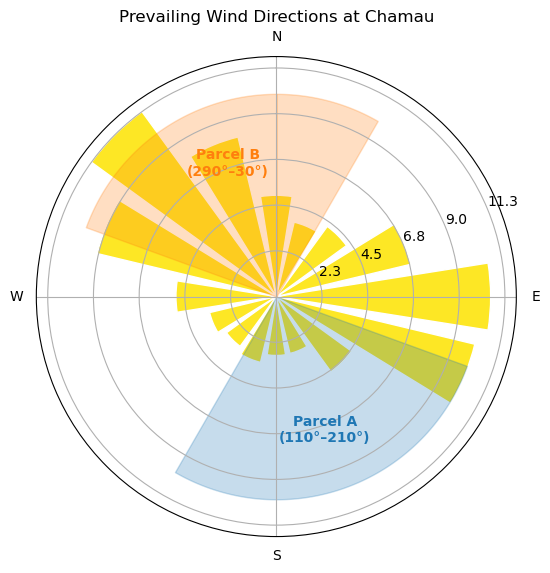

In [11]:
# WIND ROSE FIGURE

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from windrose import WindroseAxes

fig = plt.figure(figsize=(6, 6))
ax = WindroseAxes.from_ax(fig=fig)

# --- Base wind rose ---
ax.bar(df["WD"], np.ones(len(df)), normed=True, opening=0.8, edgecolor="white")
plt.title("Prevailing Wind Directions at Chamau")

# --- Highlight Parcel A (110°–210°) ---
theta_A = np.deg2rad(np.linspace(110, 210, 200))
ax.fill_between(theta_A, 0, 10, color="tab:blue", alpha=0.25, label="Parcel A")

# --- Highlight Parcel B (290°–360° and 0°–30°) ---
theta_B1 = np.deg2rad(np.linspace(290, 360, 100))
theta_B2 = np.deg2rad(np.linspace(0, 30, 100))
ax.fill_between(theta_B1, 0, 10, color="tab:orange", alpha=0.25, label="Parcel B")
ax.fill_between(theta_B2, 0, 10, color="tab:orange", alpha=0.25)

# --- Make North (0°) point upward and increase clockwise ---
ax.set_theta_zero_location("N")   # 0° at top
ax.set_theta_direction(-1)        # Clockwise angles

# --- Add cardinal directions ---
ax.set_thetagrids(angles=[0, 90, 180, 270], labels=["N", "E", "S", "W"])

# --- Legend + layout ---
ax.text(np.deg2rad(160), 7, "Parcel A\n(110°–210°)",
        ha="center", va="center", fontsize=10, color="tab:blue", weight="bold")

ax.text(np.deg2rad(340), 7, "Parcel B\n(290°–30°)",
        ha="center", va="center", fontsize=10, color="tab:orange", weight="bold")

plt.show()


In [12]:
len(chamau_lag)

15851

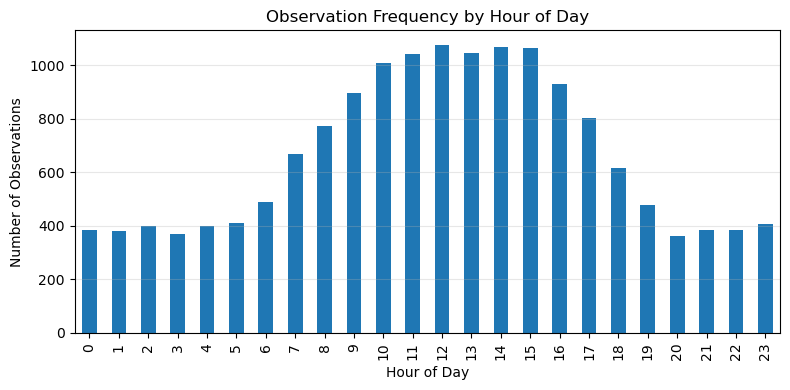

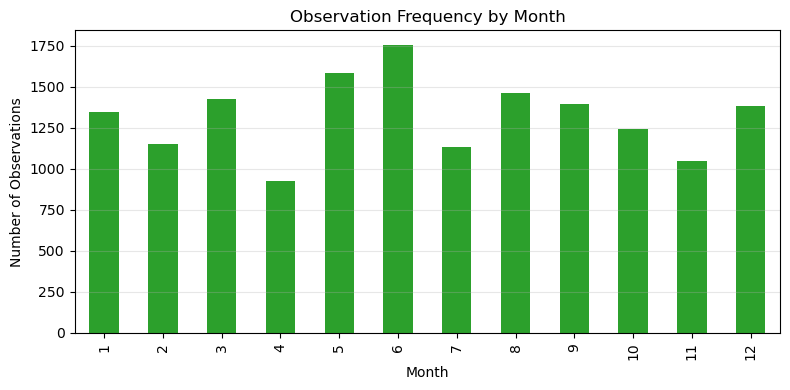

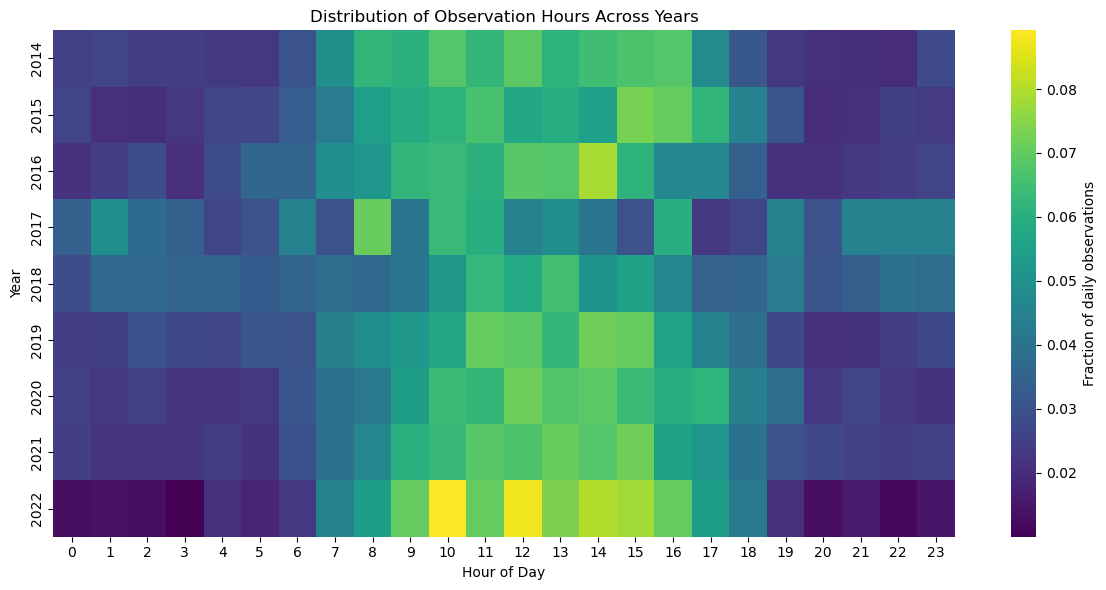

In [13]:
# count observations per hour
hourly_counts = chamau_lag["hour"].value_counts().sort_index()

# plot
plt.figure(figsize=(8,4))
hourly_counts.plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Observations")
plt.title("Observation Frequency by Hour of Day")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# count per month
monthly_counts = chamau_lag["month"].value_counts().sort_index()

# plot
plt.figure(figsize=(8,4))
monthly_counts.plot(kind="bar", color="tab:green")
plt.xlabel("Month")
plt.ylabel("Number of Observations")
plt.title("Observation Frequency by Month")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# group by year × hour
hour_year_counts = (
    chamau_lag.groupby(["year", "hour"])
    .size()
    .unstack(fill_value=0)
)

# normalize by total per year (to compare proportions)
hour_year_norm = hour_year_counts.div(hour_year_counts.sum(axis=1), axis=0)

# plot as heatmap
plt.figure(figsize=(12,6))
sns.heatmap(hour_year_norm, cmap="viridis", cbar_kws={"label": "Fraction of daily observations"})
plt.xlabel("Hour of Day")
plt.ylabel("Year")
plt.title("Distribution of Observation Hours Across Years")
plt.tight_layout()
plt.show()



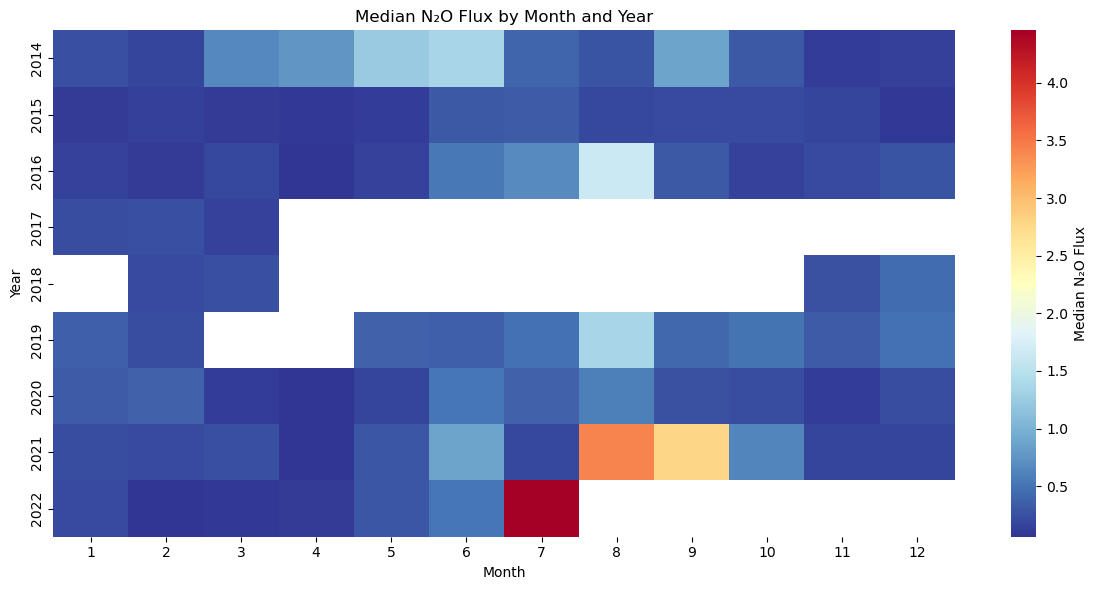

/tmp/ipykernel_259326/1499290335.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chamau_lag.groupby(["T4_bin", "T15_bin"])["N2O_Flux"]


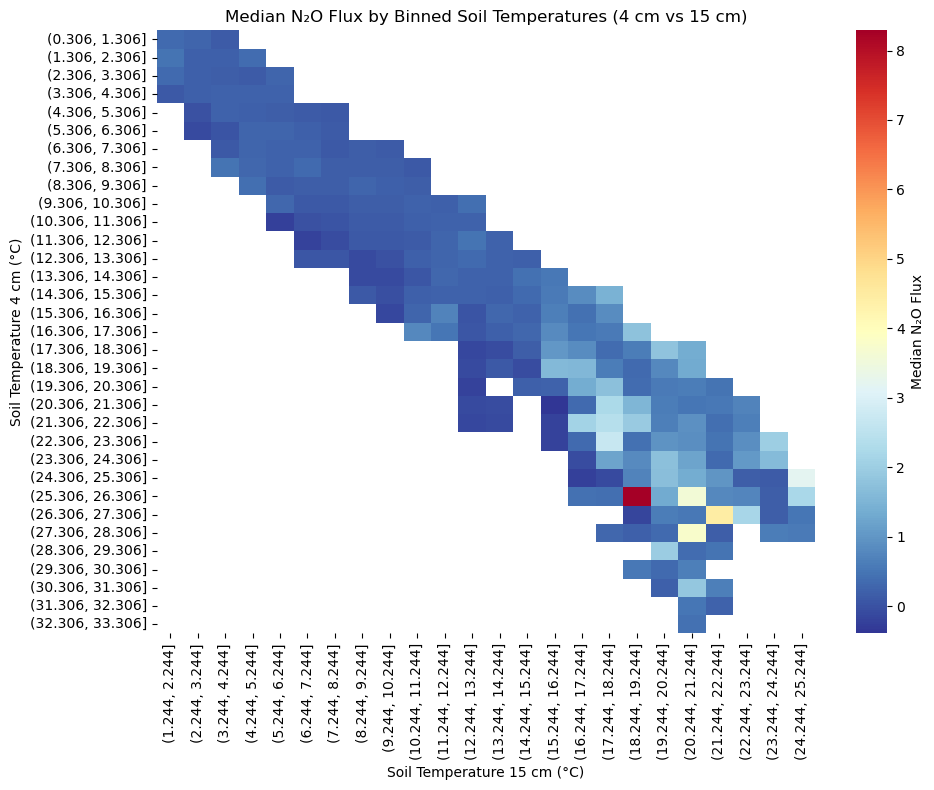

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# compute median N₂O flux per year × hour
median_flux = (
    chamau_lag.groupby(["year", "month"])["N2O_Flux"]
    .median()
    .unstack(fill_value=np.nan)
)

# plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(
    median_flux,
    cmap="RdYlBu_r",
    cbar_kws={"label": "Median N₂O Flux"},
)
plt.xlabel("Month")
plt.ylabel("Year")
plt.title("Median N₂O Flux by Month and Year")
plt.tight_layout()
plt.show()

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define bin edges for both temperatures
bins_4cm = np.arange(chamau_lag["SoilTemp_4cm"].min(), chamau_lag["SoilTemp_4cm"].max()+1, 1)
bins_15cm = np.arange(chamau_lag["SoilTemp_15cm"].min(), chamau_lag["SoilTemp_15cm"].max()+1, 1)

# create binned categories
chamau_lag["T4_bin"] = pd.cut(chamau_lag["SoilTemp_4cm"], bins=bins_4cm)
chamau_lag["T15_bin"] = pd.cut(chamau_lag["SoilTemp_15cm"], bins=bins_15cm)

# compute median flux per 2D bin
median_flux_binned = (
    chamau_lag.groupby(["T4_bin", "T15_bin"])["N2O_Flux"]
    .median()
    .unstack(fill_value=np.nan)
)

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    median_flux_binned,
    cmap="RdYlBu_r",
    cbar_kws={"label": "Median N₂O Flux"},
)
plt.xlabel("Soil Temperature 15 cm (°C)")
plt.ylabel("Soil Temperature 4 cm (°C)")
plt.title("Median N₂O Flux by Binned Soil Temperatures (4 cm vs 15 cm)")
plt.tight_layout()
plt.show()

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_time_series(df, vars_to_plot):
    """
    Plot time series of selected variables with real time gaps shown on the x-axis.
    Automatically formats time labels and adds axis labels.
    """
    df = df.copy().sort_index()

    # --- Ensure datetime index ---
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # --- Layout ---
    n_cols = 3
    n_rows = int(len(vars_to_plot) / n_cols) + (len(vars_to_plot) % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), sharex=True)
    axes = axes.flatten()

    # --- Plot each variable ---
    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        ax.plot(df.index, df[var], lw=1)
        ax.set_title(var, fontsize=10)
        ax.set_ylabel(var)
        ax.grid(True, alpha=0.3)

        # Format the x-axis as dates
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.tick_params(axis='x', rotation=45)

    # --- Remove unused axes if any ---
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # --- Common labels and formatting ---
    fig.suptitle("Time Series", fontsize=14)
    fig.text(0.5, 0.04, "Date", ha='center', fontsize=12)
    fig.tight_layout(rect=[0, 0.05, 1, 0.97])
    plt.show()


Raw Data


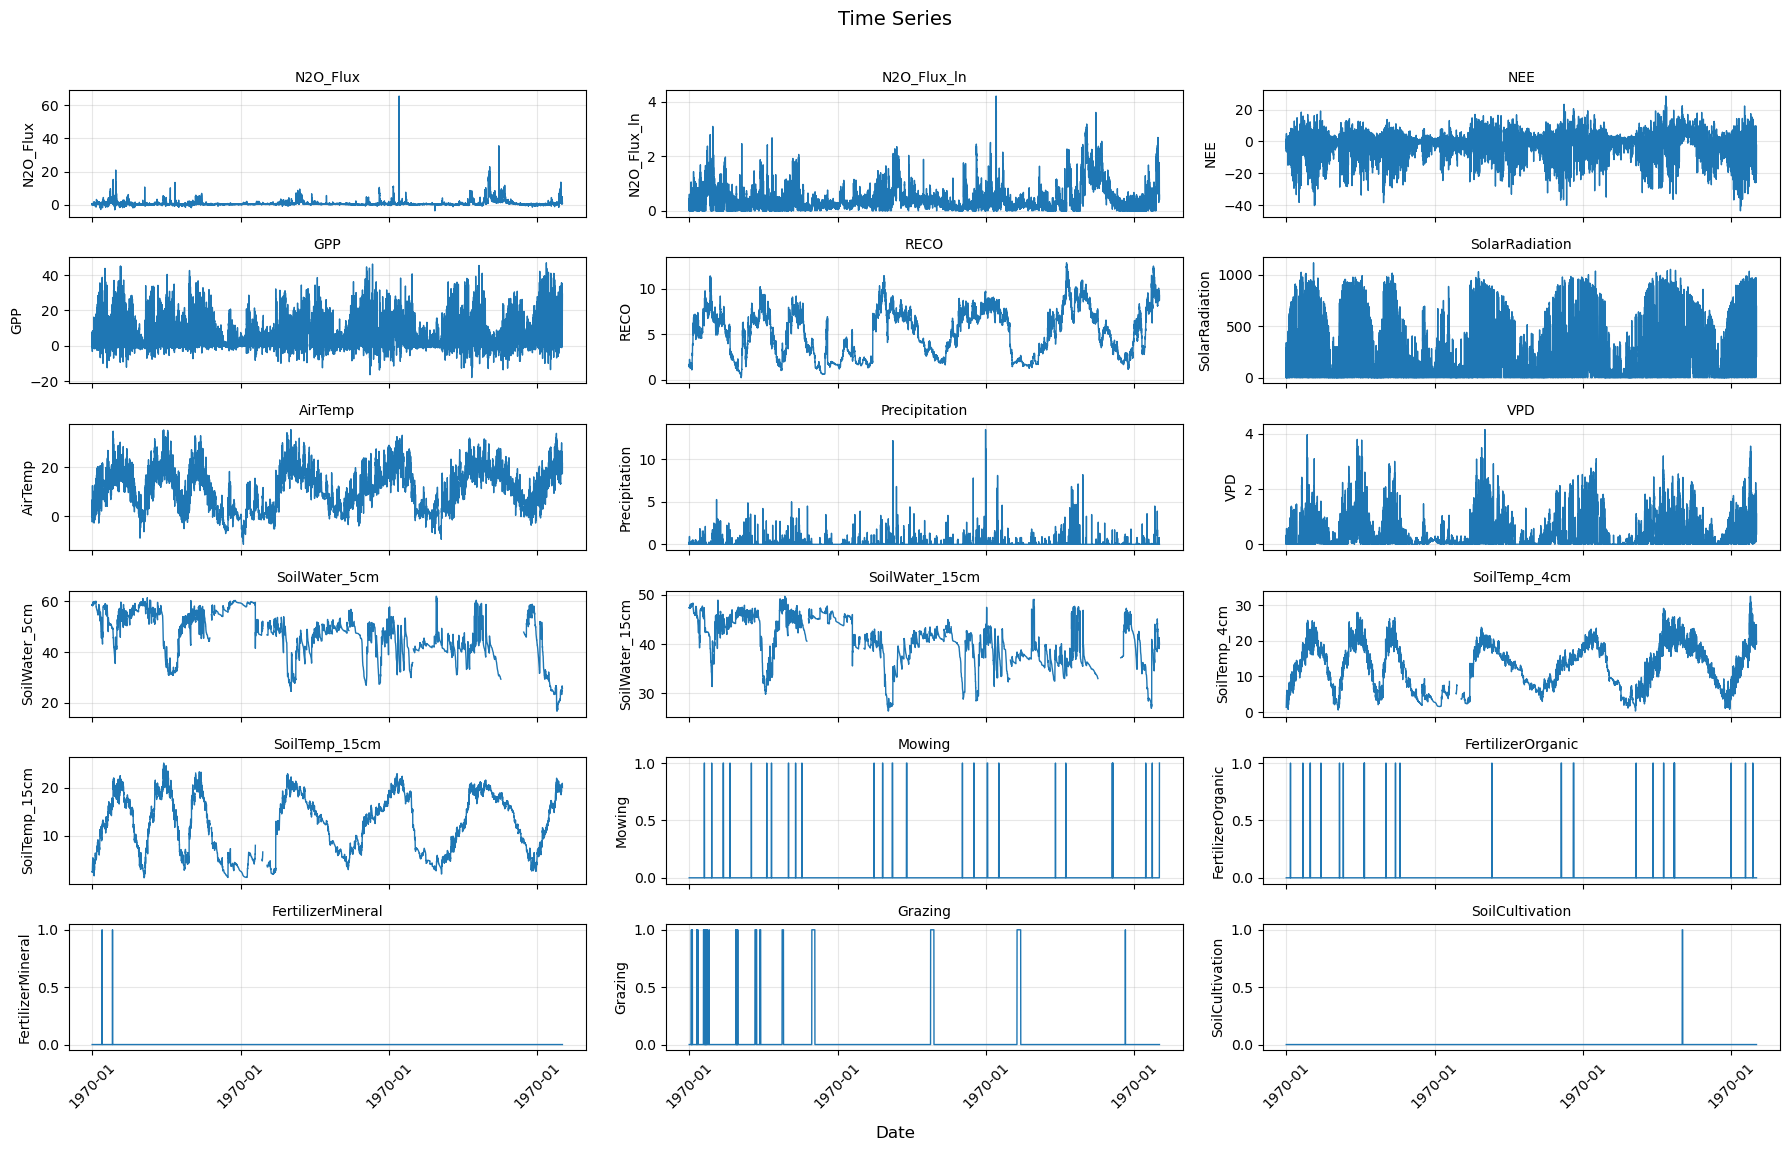

Daily Freq


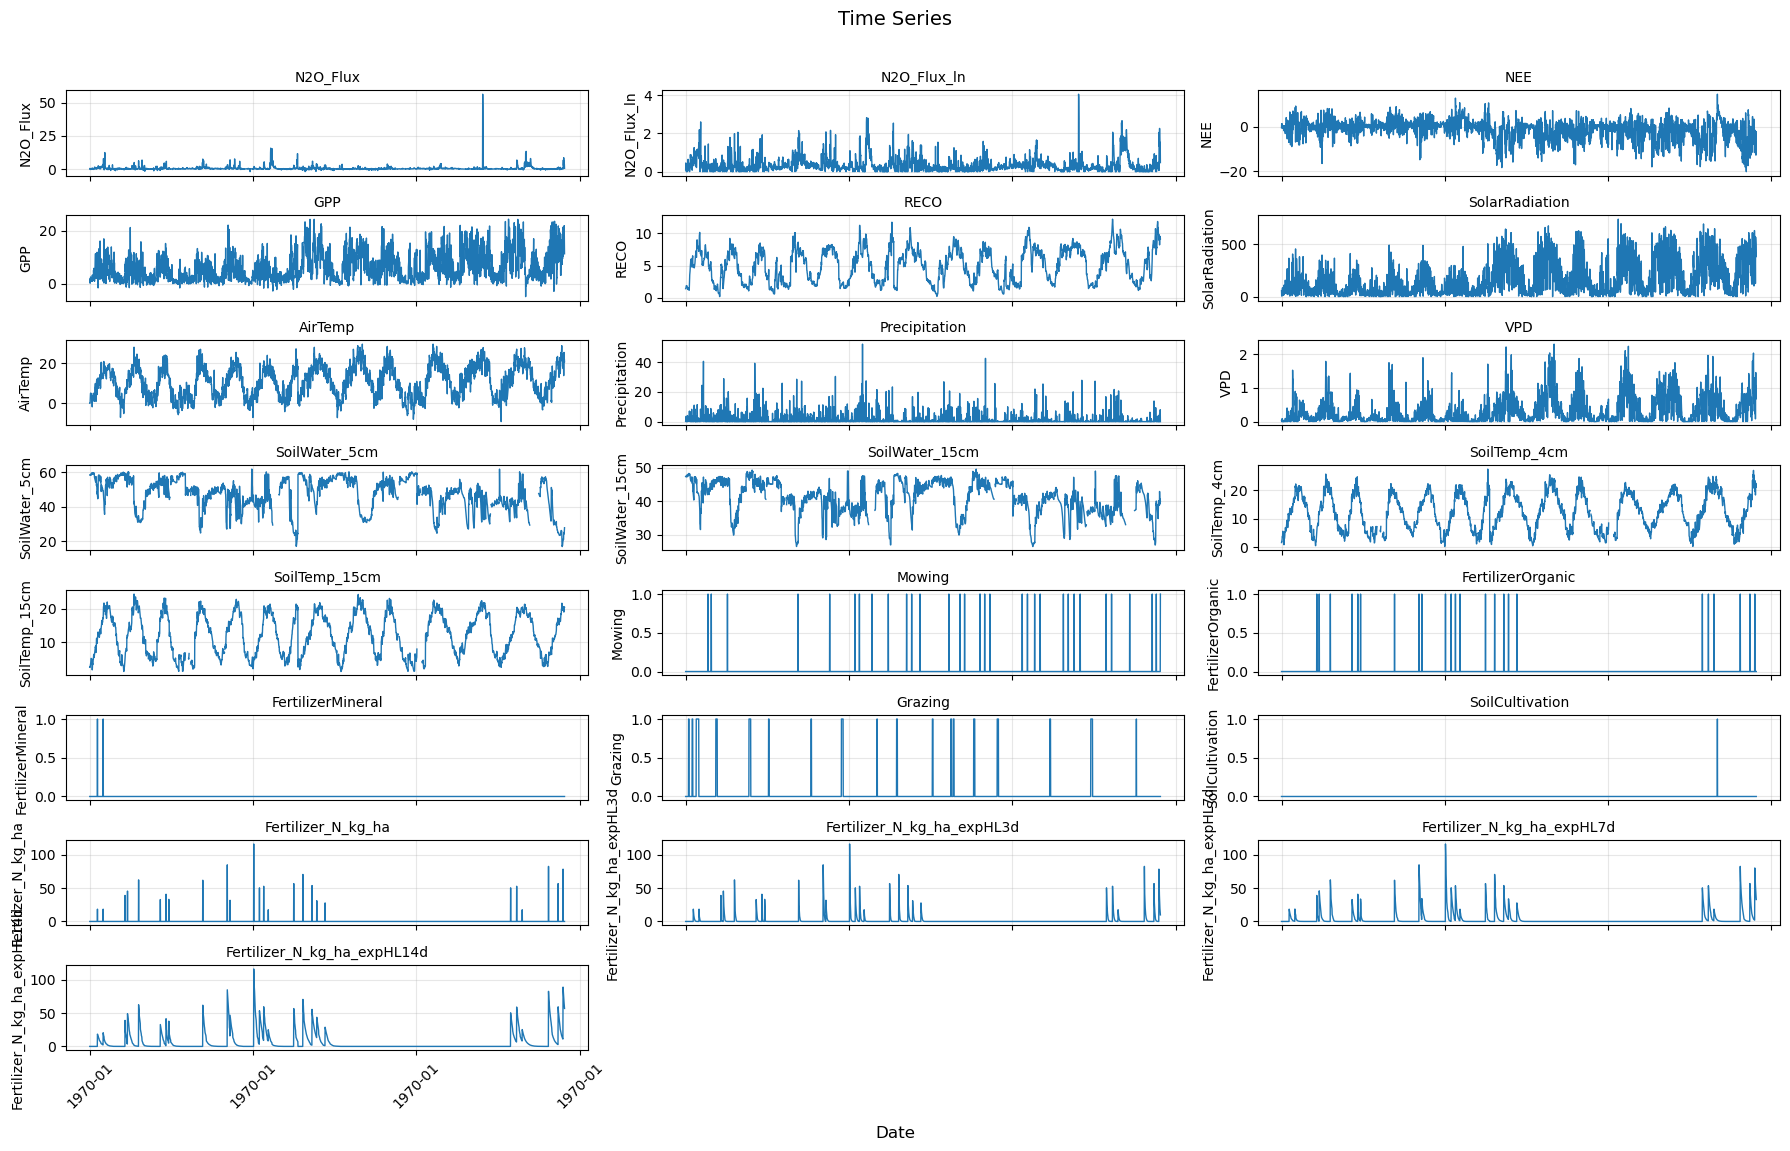

In [19]:
vars_to_plot = [
    "N2O_Flux", "N2O_Flux_ln", "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation",
    "VPD", "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
]

vars_to_plot_w_fert = [
    "N2O_Flux", "N2O_Flux_ln", "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation",
    "VPD", "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
    "Fertilizer_N_kg_ha", "Fertilizer_N_kg_ha_expHL3d", 	
    "Fertilizer_N_kg_ha_expHL7d", "Fertilizer_N_kg_ha_expHL14d"
]

# Daily averages
print("Raw Data")
plot_time_series(chamau_lag, vars_to_plot)
print("Daily Freq")
plot_time_series(chamau_daily, vars_to_plot_w_fert)

In [ ]:
chamau_lag

### ANALYZE EFFECTS OF FIELD MANAGEMENT

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Identify fertilization events ---
fert_events = chamau_daily[
    (chamau_daily["FertilizerOrganic"] == 1) |
    (chamau_daily["FertilizerMineral"] == 1)
].copy()

chamau_daily["Date"] = pd.to_datetime(chamau_daily["Date"], errors="coerce")
print(f"Found {len(fert_events)} fertilization events:")

# --- Extract N₂O fluxes for 14 days after each event (same parcel) ---
window_days = 14
records = []

for _, event in fert_events.iterrows():
    parcel = event["Parcel"]
    event_date = pd.to_datetime(event["Date"])
    subset = chamau_daily[
        (chamau_daily["Parcel"] == parcel) &
        (chamau_daily["Date"] >= event_date) &
        (chamau_daily["Date"] <= event_date + pd.Timedelta(days=window_days))
    ].copy()
    
    subset["days_since_fert"] = (subset["Date"] - event_date).dt.days
    subset["event_date"] = event_date
    subset["parcel"] = parcel
    subset["fert_type"] = (
        "Organic" if event["FertilizerOrganic"] == 1 else "Mineral"
    )
    records.append(subset)

fert_windows = pd.concat(records, ignore_index=True)

# --- Plot setup (2x2 grid) ---
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharey=True)
fig.suptitle("N₂O Flux response after fertilization (14-day window)", fontsize=14)

# Helper function to plot multiple events
def plot_events(ax, df, title):
    for (parcel, event_date), group in df.groupby(["parcel", "event_date"]):
        ax.plot(group["days_since_fert"], group["N2O_Flux"], marker="o", alpha=0.8)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Days since fertilization")
    ax.set_ylabel("N₂O Flux")

# --- Generate each panel ---
# (a) All events
plot_events(axes[0, 0], fert_windows, "All events")

# (b) Parcel A
plot_events(axes[0, 1], fert_windows[fert_windows["parcel"] == "A"], "Parcel A")

# (c) Parcel B
plot_events(axes[1, 0], fert_windows[fert_windows["parcel"] == "B"], "Parcel B")

# (d) Organic vs Mineral
for fert_type, group in fert_windows.groupby("fert_type"):
    mean_curve = group.groupby("days_since_fert")["N2O_Flux"].mean()
    axes[1, 1].plot(mean_curve.index, mean_curve.values, marker="o", label=fert_type)
axes[1, 1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[1, 1].set_title("Average by fertilizer type")
axes[1, 1].set_xlabel("Days since fertilization")
axes[1, 1].legend(title="Fertilizer Type")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

# ==========================================================
# 1️⃣ Helper: extract N₂O flux windows after each management event
# ==========================================================
def extract_event_windows(df_daily, event_col, window_days=14):
    """
    Extract N₂O flux time windows following a management event.

    Args:
        df_daily : daily dataframe (must include Date, Parcel, N2O_Flux, event_col)
        event_col : column name for event (e.g., "Mowing")
        window_days : number of days after event to include
    """
    records = []
    events = df_daily[df_daily[event_col] == 1].copy()
    if events.empty:
        return pd.DataFrame()

    for _, event in events.iterrows():
        parcel = event["Parcel"]
        event_date = pd.to_datetime(event["Date"])
        subset = df_daily[
            (df_daily["Parcel"] == parcel) &
            (df_daily["Date"] >= event_date) &
            (df_daily["Date"] <= event_date + pd.Timedelta(days=window_days))
        ].copy()

        subset["days_since_event"] = (subset["Date"] - event_date).dt.days
        subset["event_date"] = event_date
        subset["parcel"] = parcel
        subset["event_type"] = event_col  # keep event label
        records.append(subset)

    return pd.concat(records, ignore_index=True)


# ==========================================================
# 2️⃣ Create windows for each management type
# ==========================================================
mow_windows   = extract_event_windows(chamau_daily, "Mowing")
graze_windows = extract_event_windows(chamau_daily, "Grazing")
cult_windows  = extract_event_windows(chamau_daily, "SoilCultivation")
fert_windows  = extract_event_windows(chamau_daily, "FertilizerOrganic")
fert_windowsM = extract_event_windows(chamau_daily, "FertilizerMineral")

# merge organic + mineral
fert_windows["event_type"] = "Organic"
fert_windowsM["event_type"] = "Mineral"
fert_windows = pd.concat([fert_windows, fert_windowsM], ignore_index=True)

# Add fertilizer amount (if available)
if "Fertilizer_N_kg_ha" not in fert_windows.columns:
    fert_windows["Fertilizer_N_kg_ha"] = 0.0

# ==========================================================
# 3️⃣ Fertilization plots
# ==========================================================
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharey=True)
fig.suptitle("N₂O Flux after fertilization (14-day window)", fontsize=14)

# normalize fertilizer N for color mapping
norm = mcolors.Normalize(
    vmin=fert_windows["Fertilizer_N_kg_ha"].min(),
    vmax=fert_windows["Fertilizer_N_kg_ha"].max()
)
cmap = cm.viridis


def plot_fert_events(ax, df, title):
    if df.empty:
        ax.set_title(f"{title}\n(no events)", fontsize=10)
        return

    n_total = df["event_date"].nunique()
    n_by_field = df.groupby("parcel")["event_date"].nunique().to_dict()

    for _, group in df.groupby(["parcel", "event_date"]):
        n_val = group["Fertilizer_N_kg_ha"].iloc[0]
        fert_type = group["event_type"].iloc[0]
        color = cmap(norm(n_val))
        linestyle = "-" if "Organic" in fert_type else ":"
        ax.plot(
            group["days_since_event"], group["N2O_Flux"],
            color=color, linestyle=linestyle, marker="o", alpha=0.9
        )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    n_text = ", ".join([f"{p}:{n}" for p, n in n_by_field.items()])
    ax.set_title(f"{title}\n(n = {n_total}, {n_text})", fontsize=11)
    ax.set_xlabel("Days since event")
    ax.set_ylabel("N₂O Flux")
    ax.grid(True, alpha=0.3)


# (a) All events
plot_fert_events(axes[0, 0], fert_windows, "All events")

# (b) Parcel A
plot_fert_events(axes[0, 1], fert_windows[fert_windows["parcel"] == "A"], "Parcel A")

# (c) Parcel B
plot_fert_events(axes[1, 0], fert_windows[fert_windows["parcel"] == "B"], "Parcel B")

# (d) Average by fertilizer type
ax = axes[1, 1]
for event_type, group in fert_windows.groupby("event_type"):
    mean_curve = group.groupby("days_since_event")["N2O_Flux"].mean()
    linestyle = "-" if "Organic" in event_type else ":"
    ax.plot(mean_curve.index, mean_curve.values,
            marker="o", label=event_type, linestyle=linestyle)
n_total = fert_windows["event_date"].nunique()
n_by_field = fert_windows.groupby("parcel")["event_date"].nunique().to_dict()
n_text = ", ".join([f"{p}:{n}" for p, n in n_by_field.items()])
ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_title(f"Average by fertilizer type\n(n = {n_total}, {n_text})", fontsize=11)
ax.legend(title="Fertilizer type", fontsize=8)
ax.grid(True, alpha=0.3)

# legend + colorbar
handles, labels = axes[1, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower left", ncol=2,
           fontsize=9, title="Fertilizer type", title_fontsize=10)
cbar_ax = fig.add_axes([0.25, 0.04, 0.5, 0.02])
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Fertilizer N (kg ha⁻¹)")

plt.tight_layout(rect=[0, 0.07, 1, 0.96])
plt.show()

# ==========================================================
# 4️⃣ Management event plots
# ==========================================================
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=False)
fig.suptitle("N₂O Flux after management events (14-day window)", fontsize=14)

management_panels = [
    (mow_windows, "Mowing", "green"),
    (graze_windows, "Grazing", "orange"),
    (cult_windows, "Soil Cultivation", "brown"),
    (fert_windows, "Fertilization", "purple")
]

for ax, (df, label, color) in zip(axes, management_panels):
    if df.empty:
        ax.set_title(f"{label}\n(no events)", fontsize=10)
        continue

    n_total = df["event_date"].nunique()
    n_by_field = df.groupby("parcel")["event_date"].nunique().to_dict()
    n_text = ", ".join([f"{p}:{n}" for p, n in n_by_field.items()])

    for parcel in df["parcel"].unique():
        mean_curve = (
            df[df["parcel"] == parcel]
            .groupby("days_since_event")["N2O_Flux"]
            .mean()
        )
        ax.plot(
            mean_curve.index, mean_curve.values,
            marker="o", label=f"{parcel}",
            color=color, linestyle="-" if parcel == "A" else "--"
        )

    ax.axvline(0, color="black", linestyle="--")
    ax.set_title(f"{label}\n(n = {n_total}, {n_text})", fontsize=11)
    ax.set_xlabel("Days since event")
    ax.set_ylabel("N₂O Flux")
    ax.legend(title="Parcel", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
hourly_mean = chamau_lag.groupby("hour")["N2O_Flux"].mean()
hourly_std  = chamau_lag.groupby("hour")["N2O_Flux"].std()

plt.figure(figsize=(8, 5))
plt.errorbar(hourly_mean.index, hourly_mean, yerr=hourly_std, fmt="-o", capsize=3)
plt.xlabel("Hour of Day")
plt.ylabel("Mean N₂O Flux")
plt.title("Average Diurnal Cycle of N₂O Flux")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

monthly_mean = chamau_lag.groupby("month")["N2O_Flux"].mean()
monthly_std  = chamau_lag.groupby("month")["N2O_Flux"].std()

plt.figure(figsize=(8, 5))
plt.errorbar(monthly_mean.index, monthly_mean, yerr=monthly_std, fmt="-o", capsize=3)
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Mean N₂O Flux")
plt.title("Seasonal Cycle of N₂O Flux")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Base setup ---
chamau_time_index = chamau_lag.copy()
chamau_time_index["Timestamp"] = pd.to_datetime(chamau_time_index["Timestamp"])
chamau_time_index = chamau_time_index.set_index("Timestamp").sort_index()

predictors = [
    "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
]

target = "N2O_Flux"

# --- Parameters ---
window_hours = 24
step_hours   = 6
max_hours    = 7 * 24
offsets      = range(0, -max_hours - step_hours, -step_hours)

# --- Rolling mean of predictors (24h backward window) ---
window = f"{window_hours}h"  # "24h"
rolling_means = chamau_time_index[predictors].rolling(window=window, closed="left").mean()

# --- Compute lag correlations (Spearman) ---
lag_corrs = {}

for var in predictors:
    corrs = []
    for offset in offsets:
        shifted = rolling_means[var].shift(freq=pd.Timedelta(hours=offset))
        aligned = chamau_time_index[[target]].join(shifted.rename("past_mean")).dropna()
        if len(aligned) > 2:
            rho, _ = spearmanr(aligned[target], aligned["past_mean"])
            corrs.append(rho)
        else:
            corrs.append(np.nan)
    lag_corrs[var] = (list(offsets), corrs)

# --- Plot results ---
plt.figure(figsize=(12, 8))
for var, (offsets, corrs) in lag_corrs.items():
    plt.plot(offsets, corrs, label=var)

plt.axvline(0, linestyle="--", lw=1)
plt.xlabel("Hours before N₂O flux measurement (negative = further in past)")
plt.ylabel("Spearman ρ (past mean condition vs N₂O Flux)")
plt.title("Time-Lagged Spearman Correlation of Past Mean Conditions vs N₂O Flux")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import spearmanr

def plot_lag_correlation(df, col, target="N2O_Flux", max_lag=60, resample_daily=True):
    """
    Compute and plot the Spearman correlation between a predictor and target variable
    over increasing day lags (calendar-based).

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a DatetimeIndex.
    col : str
        Column name of the predictor variable (e.g. "Precipitation").
    target : str, optional
        Column name of the target variable, by default "N2O_Flux".
    max_lag : int, optional
        Maximum lag in days, by default 60.
    resample_daily : bool, optional
        If True, resample to daily mean (useful if data is sub-daily).

    Returns
    -------
    pd.DataFrame
        DataFrame with 'lag' and 'spearman_r' for each lag.
    """

    # --- Ensure datetime index ---
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # --- Optional daily resampling ---
    if resample_daily:
        df = df.select_dtypes(include=[np.number]).resample("D").mean()

    # --- Filter for valid positive flux values ---
    df = df[df[target] >= 0][[col, target]].dropna(subset=[target])

    # --- Compute lag correlations ---
    lags = np.arange(0, max_lag + 1)
    corrs = []

    for lag in lags:
        shifted = df[col].shift(freq=pd.to_timedelta(lag, unit="D"))
        aligned = pd.concat([df[target], shifted], axis=1, join="inner").dropna()

        if aligned.empty:
            corrs.append(np.nan)
        else:
            r, _ = spearmanr(aligned[target], aligned[col])
            corrs.append(r)

    # --- Store results ---
    result = pd.DataFrame({"lag_days": lags, "spearman_r": corrs})

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    plt.plot(result["lag_days"], result["spearman_r"], marker="o", color="tab:blue")
    plt.axhline(0, color="gray", lw=1)
    plt.xlabel(f"Lag (days after {col})")
    plt.ylabel("Spearman ρ")
    plt.title(f"Spearman correlation between {col} and future {target}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Report peak correlation ---
    best_lag = result["lag_days"].iloc[np.nanargmax(result["spearman_r"])]
    best_r = np.nanmax(result["spearman_r"])
    print(f"Peak Spearman correlation at lag = {best_lag} days (ρ = {best_r:.3f})")

plot_lag_correlation(chamau_time_index, col="Precipitation", max_lag=60)
plot_lag_correlation(chamau_time_index, col="AirTemp", max_lag=45)
plot_lag_correlation(chamau_time_index, col="VPD", max_lag=30)

In [ ]:
def cross_correlation_per_parcel(df, predictor_vars, target="N2O_Flux", max_lag=60):
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"])
            df = df.set_index("Date")
        else:
            raise ValueError("DataFrame must have a DatetimeIndex or 'Date' column")

    df = df[df[target] >= 0].dropna(subset=[target])
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    predictor_vars = [v for v in predictor_vars if v in numeric_cols]
    lags = np.arange(-max_lag, max_lag + 1)
    parcels = df["Parcel"].unique()
    results_dict = {}

    fig, axes = plt.subplots(1, len(parcels), figsize=(14, 5), sharey=True)
    if len(parcels) == 1:
        axes = [axes]

    for ax, parcel in zip(axes, parcels):
        sub = df[df["Parcel"] == parcel].copy().sort_index()
        corrs_dict = {}

        for var in predictor_vars:
            corrs = []
            for lag in lags:
                shifted = sub[var].shift(freq=pd.to_timedelta(lag, unit="D"))
                aligned = pd.concat([sub[target], shifted], axis=1, join="inner").dropna()
                rho = np.nan if aligned.empty else spearmanr(aligned[target], aligned[var])[0]
                corrs.append(rho)
            corrs_dict[var] = corrs

        for var, corrs in corrs_dict.items():
            ax.plot(lags, corrs, lw=1.2, label=var)

        ax.axhline(0, color="gray", lw=1)
        ax.axvline(0, color="gray", lw=1, ls="--")
        ax.set_xlabel("Lag (days)")
        ax.set_title(f"Parcel {parcel}")
        ax.grid(True, alpha=0.3)
        results_dict[parcel] = corrs_dict

    axes[0].set_ylabel("Spearman ρ")
    fig.suptitle("Cross-correlation between predictors and N₂O flux (per parcel)", fontsize=13)
    fig.legend(predictor_vars, loc="upper center", ncol=3, fontsize=9)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

    # --- Summary ---
    summary_rows = []
    for parcel in parcels:
        for var, corrs in results_dict[parcel].items():
            best_idx = np.nanargmax(np.abs(corrs))
            summary_rows.append({
                "Parcel": parcel,
                "Variable": var,
                "Best lag (days)": int(lags[best_idx]),
                "Max corr (ρ)": corrs[best_idx],
            })

    summary_df = pd.DataFrame(summary_rows)
    summary_df = (
        summary_df
        .sort_values(
            by=["Parcel", "Max corr (ρ)"],
            ascending=[True, False],
            key=lambda col: np.abs(col) if col.name == "Max corr (ρ)" else col
        )
        .round(3)
    )

    return summary_df

In [ ]:
predictors = [
    "Precipitation", "AirTemp", "VPD", "GPP", "RECO",
    "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm"
]

summary = cross_correlation_per_parcel(chamau_daily, predictor_vars=predictors, max_lag=60)
print(summary)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def train_rf_timeseries(df, predictors, target,
                        test_size=0.3, n_estimators=300, random_state=42, plot=True):
    """
    Train a Random Forest on time-series data using a chronological split.
    """

    # --- ensure time order ---
    df = df.sort_index().copy()

    # --- extract features/target ---
    X = df[predictors]
    y = df[target]

    # --- handle NaNs ---
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]

    # --- offset for positivity ---
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset

    # --- chronological split ---
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]


    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test  = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")

    # --- train model ---
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)

    # --- predictions ---
    y_pred = rf.predict(X_test)

    # revert offset
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset

    # --- evaluation ---
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)

    # --- feature importance ---
    importances = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)

    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")

    # --- plot ---
    if plot:
        plt.figure(figsize=(6, 5))
        plt.scatter(y_test_lin, y_pred_lin, alpha=0.6)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.xlabel("Observed N₂O Flux")
        plt.ylabel("Predicted N₂O Flux")
        plt.title(f"Chronological RF (R²={r2:.2f}, ρ={rho:.2f})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "model": rf,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
    }


In [ ]:
import pandas as pd

# --- Define predictor groups ---
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
        "Grazing", "SoilCultivation"
    ],

    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",

        # Meteorological lag variables
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # Management and days since management
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],

    "main": [
        "AirTemp", "VPD",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ]
}

# --- Define datasets (includes split daily A/B) ---
datasets = {
    "Hourly": chamau_lag,
    "Hourly A": chamau_A,
    "Hourly B": chamau_B,
    "Daily A": chamau_daily_A,
    "Daily B": chamau_daily_B,
    "Daily": chamau_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

# --- Run training loop ---
results_summary = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, predictors in predictor_sets.items():
            print(f"\n--- Training on {df_name} | target={target} | predictors={set_name} ---")
            try:
                res = train_rf_timeseries(
                    df=df,
                    predictors=predictors,
                    target=target,
                    plot=False  # suppress plotting
                )
                results_summary.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictor_Set": set_name,
                    "R²": res["r2"],
                    "Spearman_ρ": res["spearman_rho"]
                })
            except Exception as e:
                print(f"Skipped {df_name} | {target} | {set_name} due to error: {e}")
                results_summary.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictor_Set": set_name,
                    "R²": None,
                    "Spearman_ρ": None
                })

# --- Combine results ---
results_df = pd.DataFrame(results_summary).round(3)
print("\n=== Summary Results ===")
display(results_df)


In [ ]:
# --- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---
print("--- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_rf_timeseries(
    df=chamau_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",

        # --- Days since management events ---
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],
    target="N2O_Flux_ln",
)
  

print("main cols")
results = train_rf_timeseries(
    df=chamau_lag,
    predictors=[
    "AirTemp", "VPD",
    "SoilTemp_4cm", "SoilTemp_15cm",
     "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------
# Helper function — drop NaNs, sort by flux
# ---------------------------------

def run_pca(df, predictors, target="N2O_Flux", title="Dataset"):
    """
    Runs PCA on the given DataFrame and returns a DataFrame with PC1, PC2, and target variable.
    Drops rows with NaNs and sorts by target for visual clarity.
    """
    df = df.dropna(subset=[target]).copy()
    df = df.sort_values(by=target)

    X = df[predictors].select_dtypes(include=[np.number]).dropna()
    y = df.loc[X.index, target]

    if len(X) == 0:
        raise ValueError(f"{title}: No valid rows after dropping NaNs.")

    X_scaled = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=X.index)
    pca_df[target] = y
    return pca_df, pca


# ---------------------------------
# Feature sets
# ---------------------------------

base_vars = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO"
]

base_plus_mgmt = base_vars + [
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
]

lag_vars = base_plus_mgmt + [
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_Grazing", "DaysSince_SoilCultivation"
]

feature_sets = {
    "Basic vars": base_vars,
    "Base + management": base_plus_mgmt,
    "Full (base + lags + days-since)": lag_vars
}

# ---------------------------------
# Run PCA on all 3 datasets
# ---------------------------------

datasets = {
    "Hourly (chamau_lag)": chamau_lag,
    "Daily (Parcel A)": chamau_daily_A,
    "Daily (Parcel B)": chamau_daily_B
}

results = {}

for dname, df in datasets.items():
    for fname, feats in feature_sets.items():
        key = f"{dname} — {fname}"
        try:
            results[key] = run_pca(df, feats, title=key)
        except Exception as e:
            print(f"Skipped {key}: {e}")

# ---------------------------------
# Plot 3×3 PCA comparison
# ---------------------------------

fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, (key, (pca_df, pca)) in enumerate(results.items()):
    ax = axes[i]
    sns.scatterplot(
        data=pca_df,
        x="PC1", y="PC2", hue="N2O_Flux",
        palette="coolwarm", ax=ax, s=40, alpha=0.7, edgecolor="none"
    )
    ax.set_title(f"{key}\n({pca.explained_variance_ratio_.sum()*100:.1f}% total variance)", fontsize=10)
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    if i == 0:
        ax.legend(title="N₂O Flux", loc="best")
    else:
        ax.get_legend().remove()

plt.suptitle("PCA comparison: Hourly vs. Daily (Parcel A & B) and feature complexity", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
loadings = pd.DataFrame(
    pca_lag.components_.T,
    index=X.columns,
    columns=["PC1", "PC2"]
)
print(loadings.sort_values("PC1", ascending=False))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (Pearson by default)
corr = chamau.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(
    corr, 
    annot=True, fmt=".2f", cmap="coolwarm",
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation matrix (including target FN2O)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------
# --- 1️⃣ t-SNE on original chamau ---
# ---------------------------------
chamau_clean = chamau.dropna(subset=["N2O_Flux"]).dropna()
chamau_clean = chamau_clean.sort_values(by="N2O_Flux", ascending=True)

X_orig = chamau_clean.drop(columns=["N2O_Flux", "Timestamp"])
y_orig = chamau_clean["N2O_Flux"]
X_orig = X_orig.select_dtypes(include=[np.number])

X_scaled_orig = StandardScaler().fit_transform(X_orig)

tsne_orig = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne_orig = tsne_orig.fit_transform(X_scaled_orig)

tsne_df_orig = pd.DataFrame(X_tsne_orig, columns=["tSNE1", "tSNE2"])
tsne_df_orig["N2O_Flux"] = y_orig.values


# ---------------------------------
# --- 2️⃣ t-SNE on chamau_lag ---
# ---------------------------------
chamau_clean_lag = chamau_lag.dropna(subset=["N2O_Flux"]).dropna()
chamau_clean_lag = chamau_clean_lag.sort_values(by="N2O_Flux", ascending=True)

X_lag = chamau_clean_lag.drop(columns=["N2O_Flux", "Timestamp"])
y_lag = chamau_clean_lag["N2O_Flux"]
X_lag = X_lag.select_dtypes(include=[np.number])

X_scaled_lag = StandardScaler().fit_transform(X_lag)

tsne_lag = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne_lag = tsne_lag.fit_transform(X_scaled_lag)

tsne_df_lag = pd.DataFrame(X_tsne_lag, columns=["tSNE1", "tSNE2"])
tsne_df_lag["N2O_Flux"] = y_lag.values


# ---------------------------------
# --- 3️⃣ Plot side by side ---
# ---------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16,7), sharex=False, sharey=False)

sns.scatterplot(
    data=tsne_df_orig,
    x="tSNE1", y="tSNE2", hue="N2O_Flux",
    palette="coolwarm", s=35, alpha=0.7, ax=axes[0]
)
axes[0].set_title("t-SNE (original features)")
axes[0].legend(title="N₂O Flux")

sns.scatterplot(
    data=tsne_df_lag,
    x="tSNE1", y="tSNE2", hue="N2O_Flux",
    palette="coolwarm", s=35, alpha=0.7, ax=axes[1]
)
axes[1].set_title("t-SNE (with lag + management features)")
axes[1].legend(title="N₂O Flux")

plt.suptitle("t-SNE comparison: original vs. lag + days-since features", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=["tSNE1", "tSNE2"])
tsne_df["FN2O"] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tsne_df, x="tSNE1", y="tSNE2",
    hue="FN2O", palette="coolwarm", s=40
)
plt.title("t-SNE embedding coloured by N₂O flux")
plt.tight_layout()
plt.show()
